array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'cp'}>,
        <AxesSubplot: title={'center': 'trestbps'}>],
       [<AxesSubplot: title={'center': 'chol'}>,
        <AxesSubplot: title={'center': 'fbs'}>,
        <AxesSubplot: title={'center': 'restecg'}>,
        <AxesSubplot: title={'center': 'thalach'}>],
       [<AxesSubplot: title={'center': 'exang'}>,
        <AxesSubplot: title={'center': 'oldpeak'}>,
        <AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'ca'}>],
       [<AxesSubplot: title={'center': 'thal'}>,
        <AxesSubplot: title={'center': 'target'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

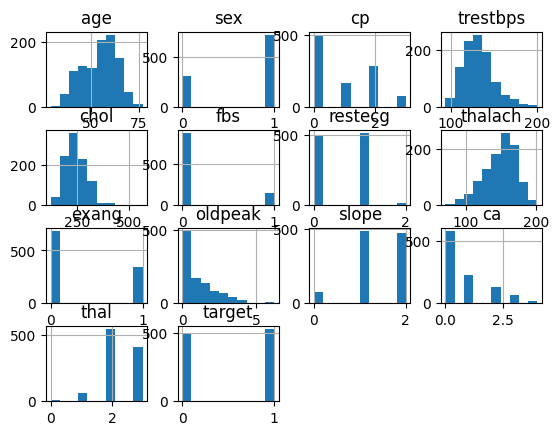

In [1]:
import pandas as pd
import seaborn as sns

data = pd.read_csv("./heart.csv", sep=",")
istogramma = data[["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"]]
data.hist()

In [2]:
import pandas as pd
import matplotlib as plb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import imblearn
from collections import Counter

def pre(data): 
    to_drop_columns = [ 'exang', 'ca', 'cp', 'slope', 'oldpeak', 'restecg']
    data.drop(to_drop_columns, axis=1, inplace=True)
    colonne_tenute = ["age","sex","trestbps","chol","fbs","thalach","thal", "target"]
    
    scaler = preprocessing.MinMaxScaler((0, 1))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data=data, columns=colonne_tenute)
    print(data)

    oversample = imblearn.over_sampling.SMOTE() #usa k-nearest-neighbours
    x_data, y_data = oversample.fit_resample(data.iloc[: , : -1], data["target"])


    return x_data, y_data
        

In [3]:
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute

x_train, y_train = pre(data)
flag = 0

for i in range (0, 50):
    cv = KFold(n_splits=10)
    model = RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_split=5, min_samples_leaf=1, max_features=6)
    score = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) #errore assoluto per 10 split
    flag = flag + mean(absolute(score))
print(flag/50)
#fa 10 volte il training e stampa la media dell'errore assoluto di ogni validazione

           age  sex  trestbps      chol  fbs   thalach      thal  target
0     0.479167  1.0  0.292453  0.196347  0.0  0.740458  1.000000     0.0
1     0.500000  1.0  0.433962  0.175799  1.0  0.641221  1.000000     0.0
2     0.854167  1.0  0.481132  0.109589  0.0  0.412214  1.000000     0.0
3     0.666667  1.0  0.509434  0.175799  0.0  0.687023  1.000000     0.0
4     0.687500  0.0  0.415094  0.383562  1.0  0.267176  0.666667     0.0
...        ...  ...       ...       ...  ...       ...       ...     ...
1020  0.625000  1.0  0.433962  0.216895  0.0  0.709924  0.666667     1.0
1021  0.645833  1.0  0.292453  0.301370  0.0  0.534351  1.000000     0.0
1022  0.375000  1.0  0.150943  0.340183  0.0  0.358779  0.666667     0.0
1023  0.437500  0.0  0.150943  0.292237  0.0  0.671756  0.666667     1.0
1024  0.520833  1.0  0.245283  0.141553  0.0  0.320611  1.000000     0.0

[1025 rows x 8 columns]
0.007746990116801436


In [4]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_split=5, min_samples_leaf=1, max_features=6)
model.fit(x_train[:700], y_train[:700])
prediction = model.predict(x_train[701:])

recall_value = recall_score(y_train[701:], prediction)
print("recall = ", recall_value)

precision_value = precision_score(y_train[701:], prediction)
print("precision = ", precision_value)

accuracy_value = accuracy_score(y_train[701:], prediction)
print("accuracy = ", accuracy_value)

fmeasure_value = f1_score(y_train[701:], prediction)
print("f1 = ", fmeasure_value)

recall =  0.9634146341463414
precision =  0.9693251533742331
accuracy =  0.9686609686609686
f1 =  0.966360856269113


In [5]:
import flask
from flask import request, jsonify
from flask import Response
import numpy as np
import pandas as pd

app = flask.Flask(__name__)

@app.route('/', methods=['POST'])
def predici():
    query_parameters = request.get_json()
    x_data = pd.DataFrame(query_parameters, index=[0])
    
    age = query_parameters["age"]
    sex = query_parameters["sex"]
    trestbps = query_parameters["trestbps"]
    chol = query_parameters["chol"]
    fbs = query_parameters["fbs"]
    thalach = query_parameters["thalach"]
    thal = query_parameters["thal"]

    v = np.array(x_data)
    print(v)

    scaler = StandardScaler()
    #scaler = preprocessing.MinMaxScaler((0, 1))

    # Calcola la media e la deviazione standard dei dati e li memorizza nell'oggetto StandardScaler
    scaler.fit(data)

    # Normalizza i dati utilizzando Z-score
    data_normalized = scaler.transform(data)

    print(x_data)


    colonne_tenute = ["age","sex","trestbps","chol","fbs","thalach","thal"]
    x_data = pd.DataFrame(data=x_data.reshape(1, 7), columns=colonne_tenute)

    print("dopo scaling \n", x_data)
    
    #chiama il modello
    result = model.predict(x_data)
    
    print(result)

    return str(result)

if __name__ == "__main__":
    app.run(port=8083)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8083
Press CTRL+C to quit
[2023-02-02 13:27:44,772] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/Users/leopoldotodisco/Desktop/HeartCare_IA/HeartCare_AI/environment/lib/python3.10/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/leopoldotodisco/Desktop/HeartCare_IA/HeartCare_AI/environment/lib/python3.10/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/leopoldotodisco/Desktop/HeartCare_IA/HeartCare_AI/environment/lib/python3.10/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/leopoldotodisco/Desktop/HeartCare_IA/HeartCare_AI/environment/lib/python3.10/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/var/folders/fx/zsdh_8412glbjpkff1h

[[50  1 90 80  0 70  0]]
